# Воркшоп по AI для архитекторов: Практикa
## Датасет

Мы уже определились с тем, какую задачу мы будем решать. Нужно выбрать подходящий набор данных! Мы предподготовили для воркшопа четыре набора размеченных данных:

* **green** - леса и парки
* **water** - водные объекты
* **residential** - жилые здания
* **non-residential** - нежилые здания

Каждый набор данных содержит две папки –– `train` (на данных из этой папки мы будем обучать нашу нейросеть) и `test` (на данных из этой папки мы будем проверять то, как работает наша нейросеть). 

В свою очередь, каждая из этих папок содержит две подпапки –– `tile` и `mask`. В папке `tile` находятся тайлы (кусочки) спутниковых снимков, а в папке `mask` для каждого такого снимка есть *маска* интересующих нас объектов с тайла.


#### Упражненьице
Нужно правильно прописать путь к папке `train`, чтобы запустить обучение на нужном датасете

In [1]:
dataset_path = '/Users/slobanova/ipynbs/workshop/datasets/water/train/'

Посмотрим на картинки из датасета (попробуйте понажимать `Tab` в процессе написания пути):

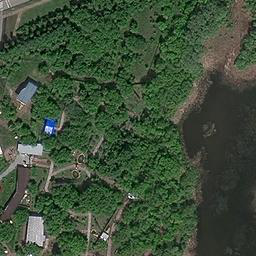

In [2]:
from PIL import Image

Image.open('/Users/slobanova/ipynbs/workshop/datasets/water/train/tile/0.79166.41078.17.sat.tile.jpg')

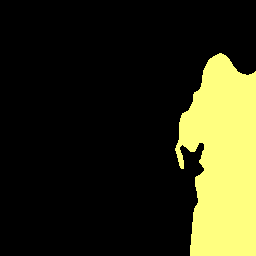

In [3]:
Image.open('/Users/slobanova/ipynbs/workshop/datasets/water/train/mask/0.79166.41078.17.mask.tile.png')

С такими парами изображений мы и будем работать. Будем пытаться находить на спутниковых снимках объекты, маски которых мы скормим нейросети.

Чтобы в дальнейшем нам не приходилось каждый раз прописывать путь полностью (абсолютный путь), напишем функцию, которая будет возвращать нам путь к папке с текущим проектом. Тогда мы сможем использовать относительные, а не абсолютные пути:

In [4]:
import os 

def get_root():
    return os.path.abspath('')

# Получим путь к папке проекта:
root = get_root()

# Выведем путь
root

'/Users/slobanova/Downloads/workshop-develop'

А тут давайте укажем название датасета, с которым хотим работать. Это понадобится нам в дальнейшем как составная часть относительного пути:

In [5]:
DATASET = 'water'

### Класс датасета

В библиотеке `torch`, которой мы собираемся пользоваться, для работы с данными, необходимо их описать особым образом. Этот способ описания позволяет привести данные к единому виду, а библиотеке обращаться к разным датасетам одного типа одинаково.

In [6]:
# Здесь мы импортируем нужные для работы кода библиотеки
import numpy as np
import torch
from torchvision import transforms as T

# Здесь мы описываем атрибуты и способы работы с нашим датасетом
class MaskDataset(object):
    # Инициализация датасета
    def __init__(self, root):
        self.root = root
        
        # Загрузка масок из папки
        masks = list(sorted(os.listdir(os.path.join(root, "mask"))))
        self.masks = []
        self.imgs = []
        
        # Для каждой маски мы находим соответствующий спутниковый снимок
        for mask_file in masks:
            img_mask_path = os.path.join(root, 'mask', mask_file)
            img_file = mask_file.replace('.mask.', '.sat.').replace('.png', '.jpg')
            img_mask = Image.open(img_mask_path).quantize(colors=256, method=2)
            img_mask = np.array(img_mask)
            if np.min(img_mask) == np.max(img_mask):
                continue

            self.masks.append(mask_file)
            self.imgs.append(img_file)

    # Обработка значений минимума и максимума для ббоксов (нужна для пограничных случаев)
    @staticmethod
    def _normalize_min_max(min_, max_):
        if min_ == max_:
            if max_ == 255:
                min_ -= 1
            else:
                max_ += 1
        elif min_ > max_:
            min_, max_ = max_, min_

        return min_, max_

    # Этот метод описывает получение объекта (пара "снимок+маска") и его свойств
    def __getitem__(self, idx):
        # Загружаем снимки и маски
        img_path = os.path.join(self.root, "tile", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])

        img_mask = Image.open(mask_path).quantize(colors=256, method=2)
        img_mask = np.array(img_mask)

        # Уникальный цвет на маске соответствует уникальному типу объекта
        obj_ids = np.unique(img_mask)
        # Первый цвет в списке - цвет фона, так что мы убираем его из списка цветов объектов
        obj_ids = obj_ids[1:]

        # Собираем бинарную маску, в которой для каждого пикселя будет говориться, есть ли на нем искомый объект
        masks = img_mask == obj_ids[:, None, None]
        masks = np.bitwise_not(masks)

        # Получаем ббоксы для каждого снимка ????
        num_objs = len(obj_ids)
        boxes = []
        try:
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])

                xmin, xmax = self._normalize_min_max(xmin, xmax)
                ymin, ymax = self._normalize_min_max(ymin, ymax)

                boxes.append([xmin, ymin, xmax, ymax])

        except IndexError as e:
            print(e)
            print(img_path)
            print(mask_path)
            raise

        # Конвертируем полученные ббоксы в тензор
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # У нас только один класс - вешаем ярлыки-единички на все объекты на снимке
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        if boxes.size()[0] > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.as_tensor(0)
        
        # Здесь описываем атрибуты объекта в нашем датасете
        target = {}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
    
        # Применяем преобразования к снимкам
        transforms = self.get_transform()
        img_tensor = transforms(Image.open(img_path).convert("RGB"))

        return img_tensor, target

    # С помощью этого метода мы сможем получать количество объектов в датасете
    def __len__(self):
        return len(self.imgs)

    # С помощью этого метода мы получаем список трансформаций - преобразований исходных элементов датасета
    def get_transform(self):
        transforms = list()
        
        # Наше единственное преобразование - перевод изображения в формат тензора (библиотека pytorch работает только с тензорами)
        transforms.append(T.ToTensor())

        return T.Compose(transforms)

Теперь мы можем загрузить данные из папки `train` в описанную структуру:

In [20]:
# Здесь мы определим размер валидационной выборки
val_subset_number = 10

# Загружаем данные из папки
whole_dataset = MaskDataset(os.path.join(root, 'datasets', DATASET, 'train'))

# Создадим список перемешанных номеров элементов датасета
indices = torch.randperm(len(whole_dataset)).tolist()

# Переопределим датасеты - теперь данные в них перемешаны
train_dataset = torch.utils.data.Subset(whole_dataset, indices[:-val_subset_number])
val_dataset = torch.utils.data.Subset(whole_dataset, indices[-val_subset_number:])

В `torch` для того, чтобы получать батчи данных из датасета, используется объект типа [DataLoader](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html):

In [21]:
import utils

# Создадим DataLoader для тренировочного датасета:
train_loader = torch.utils.data.DataLoader(
    train_dataset, # Здесь мы определяем датасет, для которого создается лодер
    batch_size=2, # Определим количество элементов в батче
    shuffle=True, # Будем перемешивать данные внутри датасета каждую эпоху
    collate_fn=utils.collate_fn # Вспомогательная функция, приводит данные в батче к определенному виду
)

# Создадим DataLoader для валидационного датасета:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

Ура! Мы разобрались с датасетом!

## Выбор модели и загрузка весов

Теперь необходимо определиться с архитектурой сети, которую мы собираемся использовать в качестве backbone. В `torch` реализовано много [моделей](https://pytorch.org/docs/stable/torchvision/models.html), мы же будем работать со следующими:
* [ResNet](https://arxiv.org/abs/1512.03385)
* [MobileNetV2](https://arxiv.org/abs/1801.04381)

Ранее вы изучали различия этих двух архитектур. Сейчас вы должны определиться с тем, какую будете использовать в этом проекте –– укажите `resnet` или `mobilenet` в поле:

In [22]:
NETWORK = 'resnet'

Следующая функция возвращает нам выбранную модель:

In [23]:
def get_model(network='resnet', num_classes = 2):
    
    import torchvision
    from torchvision.models.detection import FasterRCNN, MaskRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

    if network == 'resnet':
        
        # Загружаем "чистую" модель
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

        # В качестве предиктора ббоксов выберем FastRCNNPredictor, меняем количество выходных нейронов на количество классов = 2
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
        return model
        
    
    if network == 'mobilenet':
        
        # Загружаем "чистую" модель
        backbone = torchvision.models.mobilenet_v2(pretrained=False).features
        backbone.out_channels = 1280
    
        # Генерируем окна разных размеров
        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0),))

        # let's define what are the feature maps that we will
        # use to perform the region of interest cropping, as well as
        # the size of the crop after rescaling.
        # if your backbone returns a Tensor, featmap_names is expected to
        # be [0]. More generally, the backbone should return an
        # OrderedDict[Tensor], and in featmap_names you can choose which
        # feature maps to use.
        # ????
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                        output_size=7,
                                                        sampling_ratio=2)


        # put the pieces together inside a FasterRCNN model ????
        model = MaskRCNN(backbone,
                         num_classes=2,
                         rpn_anchor_generator=anchor_generator,
                         box_roi_pool=roi_pooler)
        
        return model
    
    else:
        print('Неправильная модель, попробуй "resnet" и "mobilenet"')
        return

Загрузим модель с помощью функции `get_model()`:

In [24]:
model = get_model(NETWORK)

Вспомогательная функция для формирования названия файла с весами (нужна будет для сохранения и загрузки весов):

In [25]:
def get_weights_filepath(epoch, dataset, network, is_train=False):

    file_segments = []

    if is_train:
        file_segments.append('train')

    if epoch is not None:
        file_segments.append('ep{}'.format(epoch))

    file_segments.append(dataset)
    file_segments.append(network)

    root = get_root()
    file_name = '_'.join(file_segments) + '.pt'
    return os.path.join(root, 'weights', file_name)

Одна из особенностей библиотеки PyTorch - возможность работы с GPU. Это позволит нам быстрее работать с моделью: тренировать ее и получать предсказания. Чтобы узнать, можем ли мы использовать GPU, запустим ячейку:

In [26]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

device.type

'cpu'

Если вы увидели `'cpu'` - чтож, обучать модель вам будет дольше по времени. Остальные могут выдохнуть. Да-да, это несправделивый мир машинного обучения, в котором вычислительные мощности решают!

#### Загрузка весов

В нашем воркшопе мы используем предподготовленные веса. Это значит, что мы будем инициализировать веса в нашей модели не случайным образом, а загрузим "сейв", который кто-то когда-то сделал для этой же архитектуры.

Все веса расположены в папке `weights`. Для каждого набора данных мы обучали сети обеих архитектур на протяжении 35-45 эпох. Результаты работы после такого обучения не идеальны, но уже гораздо лучше, чем после случайной инициализации. В этом модуле мы загрузим веса в модель:

In [27]:
weights_file = DATASET + '_' + NETWORK + '_' + 'initial_weights.pt'

WEIGHTS = os.path.join(root, 'weights', weights_file)

if not os.path.isfile(WEIGHTS):
    print('Нет таких весов!')

# Загружаем веса
model.load_state_dict(torch.load(WEIGHTS, map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(WEIGHTS))

# Загружаем модель в память устройства
model.to(device);

### Оптимизатор и гиперпараметры

_<..Вставьте еще одну лекцию и сто презентаций..>_

Оптимизатор - движущая сила всего процесса обучения. Именно он занимается обновлением весов модели, поэтому от того, как мы его зададим, зависит то, насколько быстро наша модель станет давать приемлемые предсказания, станет ли она их давать вообще и в принципе весь результат.

Вот [тут](https://pytorch.org/docs/stable/optim.html) можно посмотреть список всех методов оптимизации, зашитых в библиотеку PyTorch. Вы можете использовать любой по желанию, если разберетесь. А если нет - в ячейке ниже уже описана парочка таких методов (я надеюсь, что к этому моменту мы уже рассказали вам про них):
* [SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)
* [Adam](https://pytorch.org/docs/stable/_modules/torch/optim/adam.html)
    

In [28]:
# Создаем список всех весов в модели
params = [p for p in model.parameters() if p.requires_grad]


# Выбираем оптимизатор и указываем его параметры

# Градиентный спуск
optimizer = torch.optim.SGD(params,
                            lr=0.005, # коэффициент скорости обучения, должен быть не слишком большим и не слишком маленьким
                            momentum=0.9, # ????
                            weight_decay=0.0005 # коэффициент затухания весов ????
                           )

# Adam
optimizer = torch.optim.Adam(params,
                             lr=0.001,
                             weight_decay=0.0005
                            )


### Обучение модели

Ну что, перейдем к самой ответственной части? Нужно собрать все вместе: датасет, модель, оптимизатор.. И обучать модель. Как обычно, параметры `NUM_EPOCHS` и `EPOCH_SAVING_RATE` останутся на ваше усмотрение, но мы настоятельно рекомендуем сохраняться не реже раза в 5 эпох, а количество эпох для обучения оценивать трезво - модель должна успеть доучиться до завтра, но при этом не __пере__обучиться.

In [29]:
# Добавляем функцию для динамического обновления коэффициента скорости обучения
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, # будем обновлять коэффициент в нашем оптимизаторе
                                               step_size=3, # каждые N эпох коэффициент будет обновляться
                                               gamma=0.1 # как будет изменяться коэффициент (new_lr = lr * gamma)
                                              )

# Количество эпох
NUM_EPOCHS = 2
# Будем сохранять веса каждые N эпох:
EPOCH_SAVING_RATE = 5

import time
from engine import train_one_epoch, evaluate

print('Начинаем обучать модель: {}'.format(time.asctime()))
print('Устройство: {}'.format(device))
print('Датасет: {}'.format(DATASET))
print('Модель: {}'.format(NETWORK))
print('Эпохи: {}'.format(NUM_EPOCHS))

print('Загруженные веса: {}'.format(WEIGHTS))

print('--- -- -- -- -- -- ---')

# Список для хранения времени обучения за эпоху
learning_ts_list = list()

loss_list = []
tr_accuracy_list = []
val_accuracy_list = []

for epoch in range(NUM_EPOCHS):
    epoch_learning_ts = time.time()

    try:
        # Тренируем одну эпоху, выводим информацию каждые 10 батчей
        losses, tr_accuracies = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)

        # Обновим коэффициент скорости обучения оптимизатора:
        lr_scheduler.step()

        # Оценка на валидационном датасете
        val_accuracies = evaluate(model, val_loader, device=device)
        
        mean_acc = float(np.mean(val_accuracies))
        
        print('Эпоха {} окончена, средняя accuracy на обучении {}%'.format(epoch, mean_acc * 100))
        
        #  Сохраним для истории loss и accuracy
        with torch.no_grad():
            loss_list.append(losses)
            tr_accuracy_list.append(float(np.mean(tr_accuracies)))
            val_accuracy_list.append(mean_acc)
            
        # Сохраняем веса в отдельный файл каждые EPOCH_SAVING_RATE эпох
        if epoch >= EPOCH_SAVING_RATE and epoch % EPOCH_SAVING_RATE == 0:
            train_weights_file_path = get_weights_filepath(epoch=epoch, dataset=DATASET, network=NETWORK, is_train=True)
            torch.save(model.state_dict(), train_weights_file_path)

    # Если произойдет какая-либо ошибка, мы хотим ее вывести и сохранить текущие веса
    except Exception as e:
        import traceback
        print(e)
        print(traceback.format_exc())

        # Сохраняем текущие веса
        train_weights_file_path = get_weights_filepath(epoch=epoch, dataset=DATASET, network=NETWORK, is_train=True)
        torch.save(model.state_dict(), train_weights_file_path)

    # Записываем, сколько времени мы потратили на эту эпоху (интересно и познавательно)
    epoch_learning_ts = time.time() - epoch_learning_ts
    learning_ts_list.append(epoch_learning_ts)
    avg_learn_time = np.mean(learning_ts_list)

    print('Время обучения: {} сек'.format(int(epoch_learning_ts)))
    print('Среднее время обучения: {} сек'.format(int(avg_learn_time)))

# Сохраняем конечные веса модели после обучения
weights_file_path = get_weights_filepath(epoch=None, dataset=DATASET, network=NETWORK, is_train=False)
torch.save(model.state_dict(), weights_file_path)

loss_aggregate = [x[0] for x in loss_list]
# loss_classifier = [x[0] for x in loss_list]
# loss_box_reg = [x[0] for x in loss_list]
# loss_mask = [x[0] for x in loss_list]

print("Вот и всё!")

Начинаем обучать модель: Fri Nov 29 01:05:26 2019
Устройство: cpu
Датасет: water
Модель: resnet
Эпохи: 2
Загруженные веса: /Users/slobanova/Downloads/workshop-develop/weights/water_resnet_initial_weights.pt
--- -- -- -- -- -- ---
Epoch: [0]  [0/5]  eta: 0:04:39  lr: 0.000251  loss: 0.8103 (0.8103)  loss_classifier: 0.0776 (0.0776)  loss_box_reg: 0.0542 (0.0542)  loss_mask: 0.6512 (0.6512)  loss_objectness: 0.0170 (0.0170)  loss_rpn_box_reg: 0.0104 (0.0104)  accuracy: 24.5327 (24.5327)  time: 55.8619  data: 0.0634
Epoch: [0]  [4/5]  eta: 0:00:53  lr: 0.001000  loss: 1.2223 (1.3214)  loss_classifier: 0.0776 (0.2097)  loss_box_reg: 0.0419 (0.0462)  loss_mask: 0.7031 (1.0077)  loss_objectness: 0.0320 (0.0450)  loss_rpn_box_reg: 0.0104 (0.0128)  accuracy: 24.5327 (20.6196)  time: 53.5901  data: 0.0701
Epoch: [0] Total time: 0:04:28 (53.6020 s / it)
Test:  [ 0/10]  eta: 0:01:06  accuracy: 87.0071 (87.0071)  model_time: 6.5198 (6.5198)  evaluator_time: 0.0000 (0.0000)  time: 6.6157  data: 0.0

### Построим график loss и метрики качества

Чтобы диагностировать проблемы при обучении, полезно иногда смотреть на то, как изменяется со временем loss и accuracy на тренировочном и валидационном датасетах. Если грубо говорить, _loss_ должна убывать со временем, а _accuracy_ расти.


NameError: name 'loss_classifier' is not defined

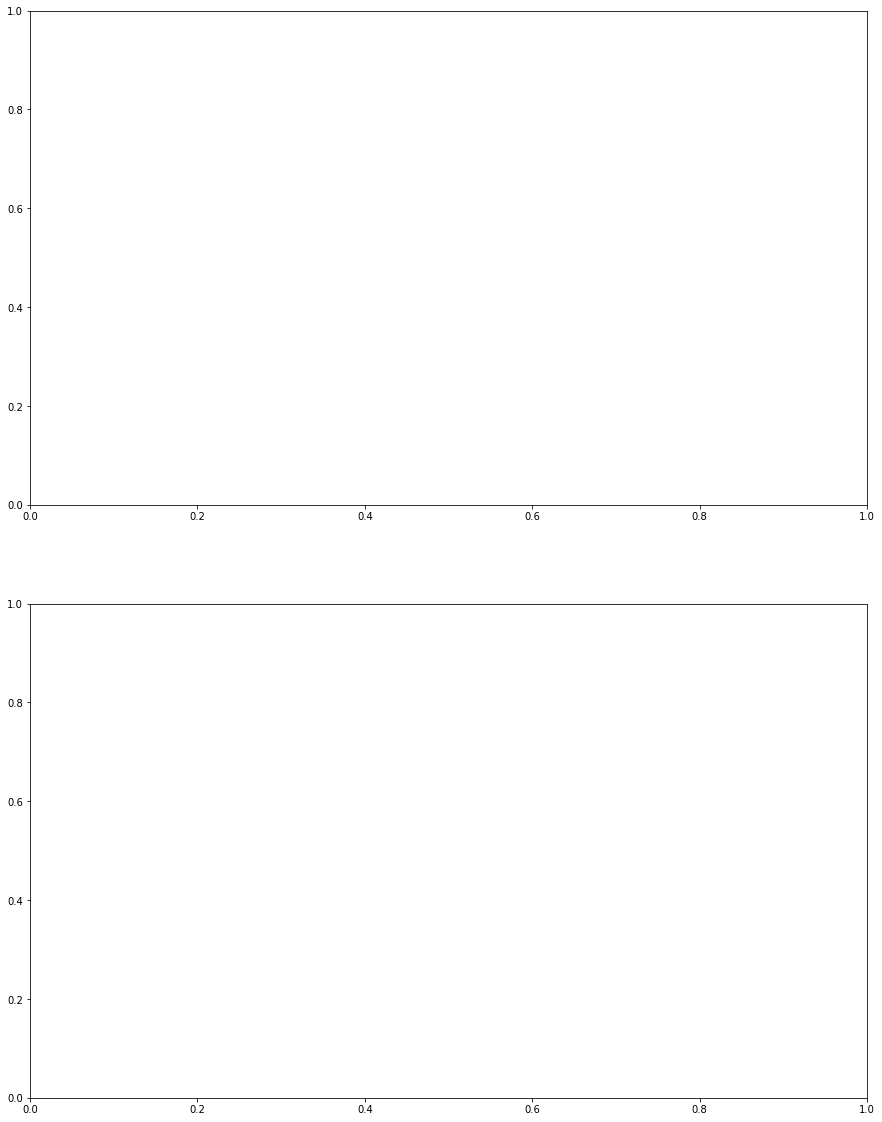

In [58]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(15, 20))


# Нарисуем первый график, он будет показывать, как изменялись loss'ы по эпохам на трейне и на валидации

ax[0].plot(list(range(len(loss_classifier))), loss_classifier, label='Classifier loss', c='c')

ax[0].plot(list(range(len(loss_box_reg))), loss_box_reg, label='Bbox regression loss', c='m')

ax[0].plot(list(range(len(loss_mask))), loss_mask, label='Mask loss', c='y')

ax[0].plot(list(range(len(loss_aggregate))), loss_aggregate, label='Aggregated loss', linewidth=3, c='0.5')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Losses')
ax[0].legend(loc='upper right')


# Нарисуем второй график, он будет показывать, как изменялись аккураси и совокупный loss по эпохам на трейне и на валидации

ax[1].plot(list(range(len(tr_accuracy_list))), tr_accuracy_list, label='Train accuracy', linestyle='--', c='y')
ax[1].plot(list(range(len(val_accuracy_list))), val_accuracy_list, label='Validation accuracy', c='y')

ax[1].plot(list(range(len(loss_aggregate))), loss_aggregate, label='Training aggregated loss', linewidth=3, linestyle='--', c='0.5')

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy & aggregated loss')
ax[1].legend(loc='upper right')

plt.show()

## Посмотрим, что же у нас вышло


Ну что, наверное хочется посмотреть, как работает наш алгоритм? Это можно сделать, посмотрев на предсказание, полученное моделью `pred = model(img)`, однако его не очень приятно читать и довольно сложно соотнести с реальным изображением. Чтобы было проще узнать, что и где нашла наша сеть, используем пару новых функций и сохраним изображения в папку `result`.

Для начала разберемся, с каким датасетом мы будем работать, и куда сохраним результаты. Если предыдущие части кода вы запускали относительно давно, то компьютеру нужно будет освежить память и задать нужные нам переменные заново.

In [64]:
# Это секция с закоментированными строками может пригодиться, если в памяти компьютера не осталось переменных с обучения

weights_file_path = '/Users/slobanova/ipynbs/workshop/weights/water_resnet_initial_weights.pt'

# model = get_model('mobilenet')

model.load_state_dict(torch.load(weights_file_path, map_location=torch.device('cpu')))

model.to(device)

# DATASET = 'water'


# Указываем путь к папке со снимками для проверки
dataset_path = os.path.join(root, 'datasets', DATASET, 'train')

# Указываем путь для сохранения итоговых изображений
result_path = os.path.join(root, 'result')

# Задаем названия лейблов для ббоксов
OBJECT_LABELS = [
    '__background__', DATASET
]

Опишем функцию, которая будет получать предсказание от модели и в зависимости от вероятности наличия объекта (вероятность больше или меньше порогового значения `threshold`) будет передавать объекты в функцию для рисования:

In [60]:
# Функция для получения списка преобразований
def get_transform(train):
    transforms = [
        T.ToTensor(),
    ]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Функция для получения предсказания для спутникого снимка
def get_prediction(img_path, threshold):
    
    # Переводим модель в режим оценки
    model.eval()
    
    img = Image.open(img_path)  # Открываем картинку
    transform = T.Compose([T.ToTensor()])  
    img = transform(img) # Применяем к ней трансформации
    
    pred = model([img])  # Получаем предсказание модели по снимку
    
    pred_class = [OBJECT_LABELS[i] for i in list(pred[0]['labels'].cpu().numpy())]  # Получаем классы распознанных объектов - лейблы
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]  # Получаем ббоксы объектов
    pred_score = list(pred[0]['scores'].detach().cpu().numpy()) # Получаем вероятности для объектов
    pred_masks = list(pred[0]['masks'].detach().cpu().numpy()) # Маски объектов
    
    print(os.path.basename(img_path))
    
    # Здесь мы выбираем объекты, вероятность которых > threshold
    
    pred_selected = [pred_score.index(x) for x in pred_score]
    
    if len(pred_selected) == 0:
        return [], [], [], []

    pred_filtered_values = [x for x in pred_score if x > threshold]
    
    if len(pred_filtered_values) == 0:
        return [], [], [], []

    print("Вероятности для всех найденных объектов: {}.".format(pred_score))

    pred_selected = [pred_score.index(x) for x in pred_score if x > threshold]
    pred_boxes = [pred_boxes[idx] for idx in pred_selected]
    pred_class = [pred_class[idx] for idx in pred_selected]
    pred_score = [pred_score[idx] for idx in pred_selected]
    pred_masks = [pred_masks[idx] for idx in pred_selected]
    
    return pred_boxes, pred_class, pred_score, pred_masks

Напишем функцию для отрисовки найденных объектов:

In [61]:
import cv2

# Функция рисования результатов обработки, сохраняет снимок с нанесенными ббоксами и отдельно предсказанную маску
def object_detection_api(img_path, threshold=0.15, rect_th=1, text_size=0.4, text_th=3):
    boxes, pred_cls, scores, masks = get_prediction(img_path, threshold)  # Получим данные о найденных объектах на снимке
    img = cv2.imread(img_path)  # Читаем изображение
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Конвертируем цвета (особенность работы с cv2)

    # Рисуем ббокс
    for i in range(len(boxes)):
        cv2.rectangle( # Добавляем прямоугольник ббокса на картинку
            img,
            boxes[i][0],
            boxes[i][1],
            color=(0, 255, 0),
            thickness=rect_th
        )
        cv2.putText( # Добавляем подпись к прямоугольнику (вероятность)
            img,
            str(scores[i]),
            boxes[i][0],
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            color=(0, 255, 0),
            thickness=1
        )

    height, width, _ = img.shape
    
    # Сделаем пустой холст для рисования маски
    heatmap_mask = np.zeros((256,256), dtype=np.uint8)
    
    # Накладываем единичные маски друг на друга
    for i in range(len(masks)):
        the_mask = masks[i][0]
        heatmap_mask = np.uint8(255 * the_mask) + heatmap_mask

    # Сохраняем изображение с ббоксами
    plt.imshow(img)
    saving_file = os.path.join(result_path, os.path.basename(img_path).replace('.sat.', '.bbox.'))
    plt.savefig(saving_file)

    # Сохраняем изображение маски
    plt.imshow(heatmap_mask)
    saving_file = os.path.join(result_path, os.path.basename(img_path).replace('.sat.', '.heat.'))
    plt.savefig(saving_file)

Теперь мы можем запустить каскад функций (параметр `threshold` можно и нужно менять):

0.76538.38199.17.sat.tile.jpg
0.76538.38255.17.sat.tile.jpg
0.76538.38212.17.sat.tile.jpg
0.76538.38220.17.sat.tile.jpg
Вероятности для всех найденных объектов: [0.509457, 0.13549332, 0.13278197, 0.122559205, 0.118021384, 0.0925096, 0.08792209, 0.07897752, 0.063216686, 0.055176836, 0.052478556, 0.050929897].
0.76538.38221.17.sat.tile.jpg
0.76538.38198.17.sat.tile.jpg
0.76538.38261.17.sat.tile.jpg
Вероятности для всех найденных объектов: [0.8147341, 0.25628495, 0.24868727, 0.18192792, 0.16146182, 0.14538392, 0.118968025, 0.11191117, 0.08254638, 0.07484587, 0.07442783, 0.06672159, 0.065158404, 0.057321347, 0.051787604].
0.76538.38229.17.sat.tile.jpg
0.76538.38197.17.sat.tile.jpg
0.76538.38211.17.sat.tile.jpg
0.76538.38256.17.sat.tile.jpg
Вероятности для всех найденных объектов: [0.7741563, 0.5431114, 0.35145834, 0.30880368, 0.23710586, 0.20193121, 0.18886349, 0.18580495, 0.17750014, 0.1740084, 0.16601089, 0.15078188, 0.11600804, 0.105642736, 0.10457939, 0.09707133, 0.08394694, 0.06956577

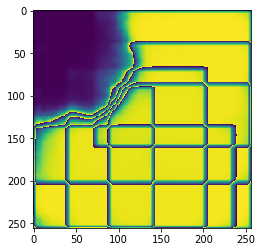

In [65]:
data = os.scandir(os.path.join(dataset_path, 'tile'))

for i, item in enumerate(data):
    object_detection_api(item.path, threshold = 0.5)
    
    # Будем смотреть первые 20 снимков
    if i == 19:
        break

Теперь можно посмотреть на эти картинки в папке. Погнали!

## Запуск на новых данных

Если вы дошли до этого этапа, то с большой вероятностью вы смогли выполнить предыдущий шаг. Сейчас мы попробуем получить результаты алгоритма на снимках Санкт-Петербурга. Эти снимки хранятся в папке `test`. Мы специально не трогали этот набор данных до последнего: сейчас мы будем смотреть, как же в реальности работает наш алгоритм на данных, которых он раньше не видел.

#### Упражненьице

* Создайте новую папку для сохранения результатов. Например, `spb_result`
* Получите обработанные сетью картинки и сохраните их в эту папку

_Не стесняйтесь спрашивать, если что-то не понятно!_

### Соберем результаты в CSV-файл